## Discretisation with Decision Trees using Feature-Engine


feature Engine allows you to implement decision tree discretisation on all your numerical variables very easily, including search over the multiple parameters of the decision tree, to find the best one.

## In this demo

We will learn how to perform discretisation with decision trees and Feature-Engine using the Titanic dataset.

In [104]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser

In [105]:
# load data

cols = ['age','fare','survived']
data = pd.read_csv('titanic.csv', usecols=cols)
data.head()


,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1309 non-null   int64  
 1   age       1046 non-null   float64
 2   fare      1308 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 30.8 KB


- We can see there are also some null values in both age and fare variables
- This also needs to be taken care

In [117]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

- Imputing the missing data in age and fare by using random sample imputation

In [5]:
df = X_train['age'].copy()
df

501     13.0000
588      4.0000
402     30.0000
1193        NaN
686     22.0000
         ...   
763      0.1667
835         NaN
1216        NaN
559     20.0000
684     32.0000
Name: age, Length: 916, dtype: float64

In [7]:
random_sample = df.dropna().sample(df.isnull().sum())
random_sample

1276    31.0
551     50.0
572     28.0
316     51.0
323     30.0
        ... 
464     32.0
42      59.0
23      42.0
1224    21.0
823     31.0
Name: age, Length: 175, dtype: float64

In [9]:
# get the index of the random sample with the ones from the missing ones
random_sample.index = df[df.isnull()].index
random_sample.index

Int64Index([1193,  971, 1284, 1027, 1023, 1255, 1114, 1034,  384, 1137,
            ...
            1077, 1262,  802,  882,  976,  705,  277, 1033,  835, 1216],
           dtype='int64', length=175)

In [10]:
# now set the random sample values to the missing variables in df
df.loc[df.isnull()] = random_sample
df.isnull().sum()

0

In [107]:
## lets write a function to perform these

def impute_na(data, variable):

    df= data.copy()
    df[variable + '_random'] = df[variable]
    
    # generate random samples
    samples = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # get the index of the missing observations
    samples.index = df[df[variable].isnull()].index
    
    # set the missing values with the samples
    df.loc[df[variable].isnull(), variable + '_random'] = samples
    
    return df[variable + '_random']

In [118]:
# replace na in both the train and test sets
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

In [69]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,40.5,7.7250
686,22.0,7.7250


In [109]:
# set up the decision tree discretiser indicating:
# cross-validation number (cv)
# how to evaluate model performance (scoring)
# the variables we want to discretise (variables)
# whether it is a target for regression or classification
# and the grid with the parameters we want to test

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

In [110]:
treeDisc.binner_dict_

{'age': GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
              param_grid={'max_depth': [1, 2, 3], 'min_samples_leaf': [10, 4]},
              scoring='accuracy'),
 'fare': GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
              param_grid={'max_depth': [1, 2, 3], 'min_samples_leaf': [10, 4]},
              scoring='accuracy')}

In [111]:
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [113]:
treeDisc.scores_dict_['age']

0.6200873362445415

In [112]:
treeDisc.binner_dict_['fare'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [114]:
treeDisc.scores_dict_['fare']

0.6888646288209607

By comparing the accuracy of the decision trees for age and fare, we can derive that fare is a better indicator of the outcome survived.

In [119]:
# transform the data

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [120]:
# inspect how many bins
train_t['age'].unique()

array([0.61111111, 0.50909091, 0.39849624, 0.31481481, 0.21428571,
       0.29411765, 0.09090909])

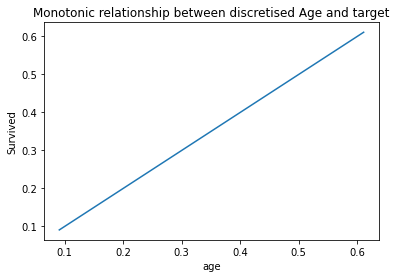

In [122]:
# monotonic relationship with target

pd.concat([train_t, y_train], axis = 1).groupby('age')['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived');

Text(0, 0.5, 'Survived')

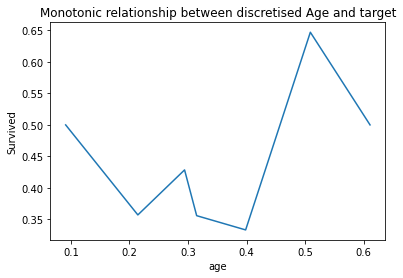

In [123]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

The monotonic relationship between bins and target is not amazing. I have to say that I needed to play quite a bit with the parameters of the tree to find the optimal tree, to keep the monotonic relationship to some degree. But, it is the trade off, like from anything else in life :)

Text(0, 0.5, 'Survived')

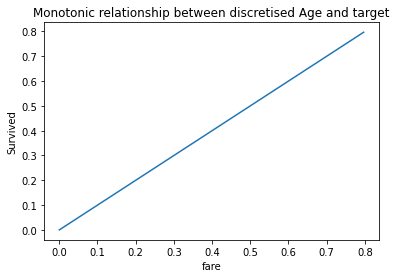

In [124]:
# let's explore the monotonic relationship for fare
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

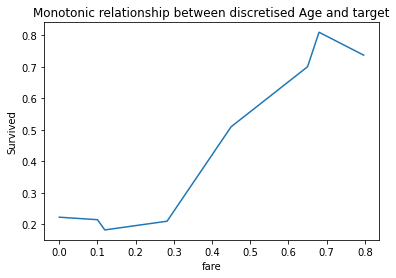

In [125]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

For fare, the monotonic relationship was preserved, almost entirely, except at the edges, which suggests that the tree could be overfitting to the train set.

Text(0, 0.5, 'Number of observations per bin')

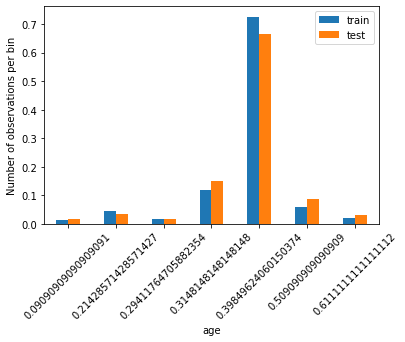

In [126]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Most of the observations are in the middle bucket, which indicates that this variable is not very predictive. 

Text(0, 0.5, 'Number of observations per bin')

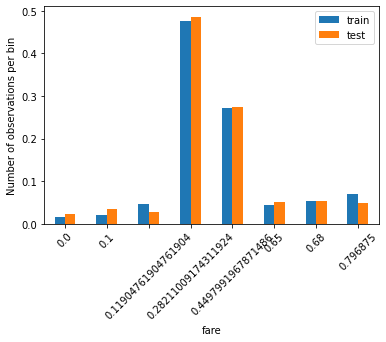

In [127]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

For fare, the tree sorted the values in more buckets, therefore creating a better value spread (remember that fare was quite skewed).